In [9]:
%%bash

rm export-fluke-2020-04-06.pkl*

wget -O export-fluke-2020-04-06.pkl "https://techionstorage.blob.core.windows.net/ai-count-models/fluke-test/export-fluke-2020-04-06.pkl"

rm: cannot remove 'export-fluke-2020-04-06.pkl*': No such file or directory
--2020-04-06 22:05:09--  https://techionstorage.blob.core.windows.net/ai-count-models/fluke-test/export-fluke-2020-04-06.pkl
Resolving techionstorage.blob.core.windows.net (techionstorage.blob.core.windows.net)... 40.83.104.208
Connecting to techionstorage.blob.core.windows.net (techionstorage.blob.core.windows.net)|40.83.104.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110369771 (105M) [application/octet-stream]
Saving to: ‘export-fluke-2020-04-06.pkl’

     0K .......... .......... .......... .......... ..........  0%  162K 11m4s
    50K .......... .......... .......... .......... ..........  0%  306K 8m28s
   100K .......... .......... .......... .......... ..........  0%  305K 7m36s
   150K .......... .......... .......... .......... ..........  0% 12.2M 5m44s
   200K .......... .......... .......... .......... ..........  0%  305K 5m46s
   250K .......... .......... .......

In [10]:
from fastai import *
from fastai.vision import *

from cellsegment.core import *
from cellsegment.inference_utils import *
from cellsegment.json_utils import *
from cellsegment.dataprep_utils import *
from cellsegment.set_directories import *
from cellsegment.markup_utils import *   #hide this otherwise recurseive 

import pandas

In [11]:
if not torch.cuda.is_available():
    # switch to CPU if not GPU
    print("No GPU using CPU")
    defaults.device = torch.device('cpu')
else:
    print("GPU found")
    defaults.device = torch.device('cuda')

#defaults.device = 'cpu'
#defaults.device = 'cuda'


def acc_metric1(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

def acc_metric2(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)[target>0]==target[target>0]).float().mean()
    
learn = load_learner('', 'export-fluke-2020-04-06.pkl')

learn.model.float()

No GPU using CPU


DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [12]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

def show_img(im, figsize=None, ax=None, alpha=None, label=None, title=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    if label: ax.legend()
    if title: ax.set_title(title)
    return ax

In [14]:
path = Path('testdata')
path_img = path/'Original'

fnames =  get_image_files(path_img)#path_tst)

print (f'Number of test tiles {len(fnames)}')

Number of test tiles 20


RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 1. Got 814 and 813 in dimension 2 at /pytorch/aten/src/TH/generic/THTensor.cpp:612

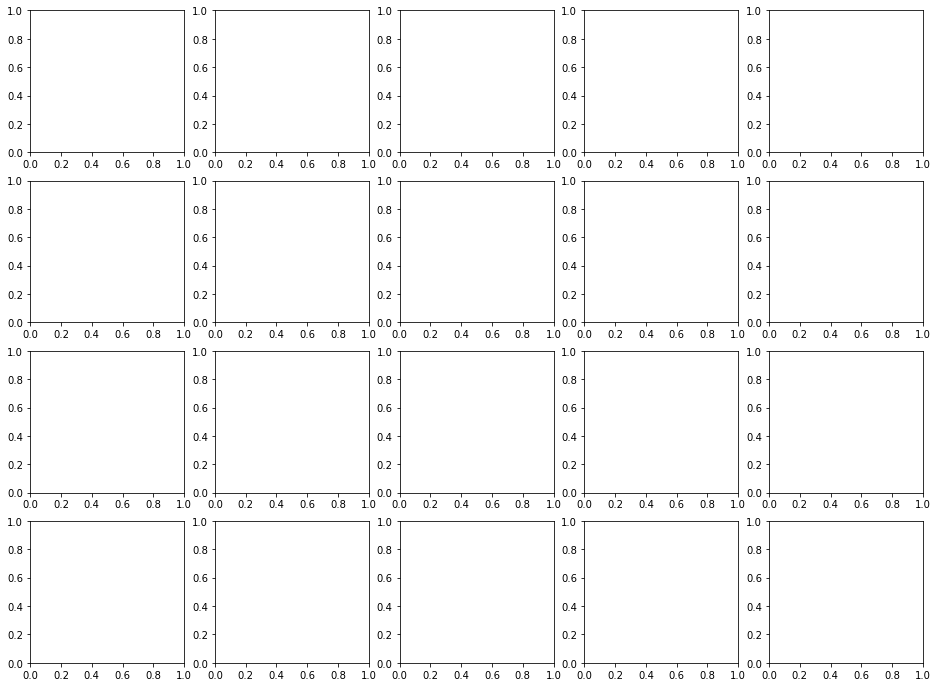

In [16]:
fnames =  sorted(get_image_files(path/'Original'))

In [36]:
dirs = Dirs('testdata')

mrk_path = Path('testdata/Original')#dirs.train+'/../markup')  
mrk_path.mkdir(parents=True, exist_ok=True)

testdata/Original/235443 - 10.jpg


[{'label': 'Liver Fluke', 'point': [117, 515], 'probability': 100},
 {'label': 'Rumen Fluke', 'point': [399, 359], 'probability': 43},
 {'label': 'Rumen Fluke', 'point': [442, 570], 'probability': 100},
 {'label': 'Other', 'point': [116, 516], 'probability': 100}]

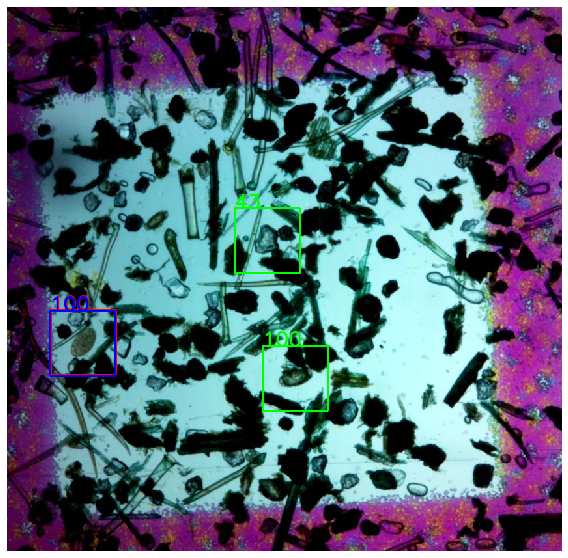

In [39]:
for fn in fnames:
    preds = run_prediction(learn, fn, tile=False, filesavedir=mrk_path)
    mrk_img, pred_list, jdata = markup_one_image(fn, preds)
    show_img(mrk_img, figsize=(10,10))
    print(fn)
    pred_list